In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tokenizers

In [ ]:
!pip install transformers tokenizers datasets

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

# Data

In [ ]:
BASE_PATH = '/content/drive/MyDrive/NLP_final'
RAW_PATH  = f'{BASE_PATH}/data/raw'
BPE_PATH  = f'{BASE_PATH}/tokenizer_bpe'
TOK_PATH  = f'{BASE_PATH}/data/tokenized'
for p in [RAW_PATH, BPE_PATH, TOK_PATH]:
    os.makedirs(p, exist_ok=True)

In [ ]:
df = pd.read_csv(f'{BASE_PATH}/clean_vi_en.csv', encoding='utf-8')
print(f"Total examples: {len(df)}")
df = df.dropna(subset=['en','vi']).drop_duplicates()
print(f"After dropna/dup: {len(df)}")

Total examples: 132106
After dropna/dup: 132106


In [ ]:
df.head(10)

,en,vi
0,"For Ms. Dewey , this isn 't why she became a t...",Đối với Dewey đây không phải là lý do mà cô tr...
1,"Nobody , literally nobody .","Không ai cả , thật sự là không ai cả ."
2,And with more and more of the world 's populat...,Và với càng nhiều dân số thế giới sống ở phần ...
3,At these large-scale construction sites in Chi...,Tại những công trường quy mô lớn đó ở Trung Qu...
4,Why can we have 29-cent Big Gulps and 99-cent ...,Sao ta có đc big gulp 29 cent và 99-cent doubl...
5,And what I have here is an empty glass vessel .,Và những gì tôi có ở đây là một bình thuỷ tinh...
6,It 's a rare condition .,Đây là một trường hợp hiếm hoi
7,Let me give you another example .,Để tôi đưa ra thêm một ví dụ
8,"So , not only does each type of pollen look di...","Nên , không chỉ mỗi loại phấn hoa trông khác n..."
9,And indeed they were .,Quả thực đúng như thế .


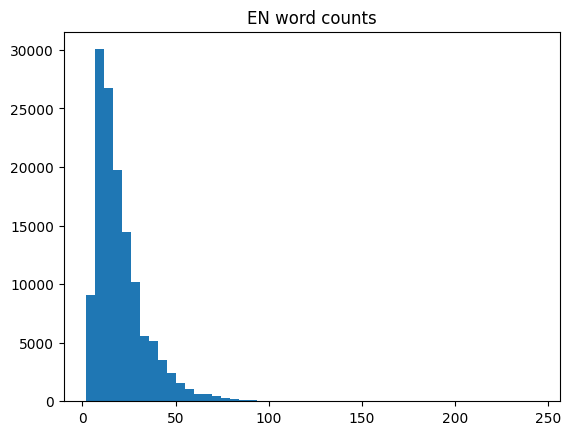

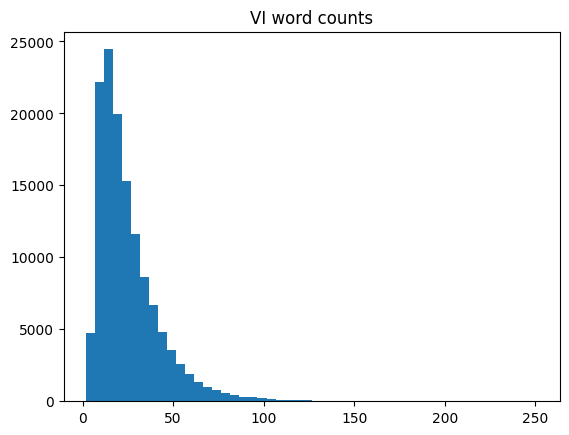

In [ ]:
df['len_en_words'] = df['en'].str.split().str.len()
df['len_vi_words'] = df['vi'].str.split().str.len()
plt.hist(df['len_en_words'], bins=50); plt.title('EN word counts'); plt.show()
plt.hist(df['len_vi_words'], bins=50); plt.title('VI word counts'); plt.show()

In [ ]:
MAX_LEN = 128
df_filtered = df[(df.len_en_words <= MAX_LEN) & (df.len_vi_words <= MAX_LEN)].copy()
print(f"Trước lọc: {len(df)}   —   Sau lọc: {len(df_filtered)}")

Trước lọc: 132106   —   Sau lọc: 131916


In [ ]:
train_val, test_df = train_test_split(df, test_size=0.10, random_state=42, shuffle=True)
train_df, val_df  = train_test_split(train_val, test_size=0.1111, random_state=42, shuffle=True)
print(len(train_df), len(val_df), len(test_df))

105685 13210 13211


In [ ]:
df_filtered.drop(columns=['len_en_words','len_vi_words'], inplace=True)

In [ ]:
train_df.to_csv(f'{RAW_PATH}/train.csv', index=False)
val_df.to_csv  (f'{RAW_PATH}/val.csv',   index=False)
test_df.to_csv (f'{RAW_PATH}/test.csv',  index=False)

In [ ]:
from tokenizers import ByteLevelBPETokenizer
save_path = f'{BPE_PATH}/model'
os.makedirs(save_path, exist_ok=True)

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(
    files=[f'{BPE_PATH}/train.en', f'{BPE_PATH}/train.vi'],
    vocab_size=32000,
    min_frequency=2,
    special_tokens=["<s>","<pad>","</s>","<unk>","<mask>"]
)
tokenizer.save_model(save_path)
print("BPE trained and saved to", save_path)

BPE trained and saved to /content/drive/MyDrive/NLP_final/tokenizer_bpe/model


In [ ]:
tokenizer_json = tokenizer._tokenizer.to_str()
with open(f"{save_path}/tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

In [ ]:
from transformers import PreTrainedTokenizerFast

BPE_MODEL = os.path.join(BASE_PATH, 'tokenizer_bpe', 'model', 'tokenizer.json')
hf_tok = PreTrainedTokenizerFast(
    tokenizer_file=BPE_MODEL,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>",
    unk_token="<unk>"
)

In [ ]:
examples = [
    "I love natural language processing.",
    "Tôi yêu xử lý ngôn ngữ tự nhiên.",
    "Generative Pretrained Transformer là mô hình mạnh mẽ."
]

for sentence in examples:
    tokens = hf_tok.tokenize(sentence)
    ids = hf_tok.convert_tokens_to_ids(tokens)
    df = pd.DataFrame({'token': tokens, 'id': ids})
    print(f"\nSentence: {sentence}")
    display(df)


Sentence: I love natural language processing.


,token,id
0,I,45
1,Ġlove,1884
2,Ġnatural,3381
3,Ġlanguage,2713
4,Ġprocessing,8516
5,.,18



Sentence: Tôi yêu xử lý ngôn ngữ tự nhiên.


,token,id
0,TÃ´i,625
1,ĠyÃªu,1442
2,Ġxá»Ń,2613
3,ĠlÃ½,1029
4,ĠngÃ´n,2302
5,Ġngá»¯,1966
6,Ġtá»±,852
7,ĠnhiÃªn,993
8,.,18



Sentence: Generative Pretrained Transformer là mô hình mạnh mẽ.


,token,id
0,Gener,24267
1,ative,1981
2,ĠPret,24830
3,rained,11822
4,ĠTrans,6945
5,form,1323
6,er,295
7,ĠlÃł,314
8,ĠmÃ´,1599
9,ĠhÃ¬nh,804


In [ ]:
def tokenize_df(df, max_length=128):
    enc_src = hf_tok(df['en'].tolist(),
                     padding='max_length',
                     truncation=True,
                     max_length=max_length)
    enc_tgt = hf_tok(df['vi'].tolist(),
                     padding='max_length',
                     truncation=True,
                     max_length=max_length)
    return {
        'input_ids': enc_src['input_ids'],
        'attention_mask': enc_src['attention_mask'],
        'labels': enc_tgt['input_ids'],
    }

In [ ]:
for split in ['train', 'val', 'test']:
    df = pd.read_csv(os.path.join(RAW_PATH, f'{split}.csv'))
    tokenized = tokenize_df(df, max_length=128)
    ds = Dataset.from_dict(tokenized)

    out_dir = os.path.join(TOK_PATH, split)
    os.makedirs(out_dir, exist_ok=True)
    ds.save_to_disk(out_dir)

    print(f"Saved tokenized {split} dataset to {out_dir}")

Saving the dataset (0/1 shards):   0%|          | 0/105685 [00:00<?, ? examples/s]

Saved tokenized train dataset to /content/drive/MyDrive/NLP_final/data/tokenized/train


Saving the dataset (0/1 shards):   0%|          | 0/13210 [00:00<?, ? examples/s]

Saved tokenized val dataset to /content/drive/MyDrive/NLP_final/data/tokenized/val


Saving the dataset (0/1 shards):   0%|          | 0/13211 [00:00<?, ? examples/s]

Saved tokenized test dataset to /content/drive/MyDrive/NLP_final/data/tokenized/test
